In [40]:
colors = {
 'C64 ROM-TAPE DATA': "red",
 'C64 ROM-TAPE HEADER': "red",
 'Header': "black",
 'MEGA-SAVE T2': "green",
 'Pause': "gray",
 'Pilot bytes': "darkgray",
 'Trailer Bytes': "lightgray",
}

In [41]:
tap_mapping = [(0, "Header")]
input_file = open("iridis-alpha.tap_report.txt", 'r')
for l in input_file.readlines():
    if "File Type" in l:
        file_type = l.split(":")[1].strip()
        continue
    if "Location" in l:
        locs = l.split(":")[1].strip()
        loc_list = [loc.strip().replace("$","") for loc in locs.split("->")]
        loc_list = [int(l,16) for l in loc_list]
        if not loc_list[1]:
            tap_mapping += [(loc_list[0], "Pause")]
            continue
        tap_mapping += [(loc_list[0], "Pilot bytes")]
        tap_mapping += [(loc_list[1], file_type)]
        tap_mapping += [(loc_list[2], "Trailer Bytes")]
tap_mapping += [(0x80a6d, "Pause")]

tap_mapping = [(l,n,colors[n]) for l,n in tap_mapping]

In [75]:

from PIL import Image, ImageColor, ImageFont, ImageDraw

def getDesc(pos):
    for i, (p,n,color) in enumerate(tap_mapping):
        if pos < p:
            return (p, ImageColor.getrgb(pcolor), pn, p - pp)
        pcolor, pn, pp = color, n, p
    return (p, ImageColor.getrgb(pcolor), pn, n-pn)

def createImage(tap_mapping, font_size, min_size):
    import math
    tap_len = tap_mapping[-1][0]
    side_len = int(math.sqrt(tap_len))
    # PIL accesses images in Cartesian co-ordinates, so it is Image[columns, rows]
    img = Image.new( 'RGB', (side_len,side_len), "black") # create a new black image
    pixels = img.load() # create the pixel map
    img_len = (img.size[0] * img.size[1])

    curr_upper, curr_color,curr_name = 0,0,0
    texts = []
    for j in range(img.size[1]):    # For every row
        for i in range(img.size[0]):    # for every col:
            pos = i + (side_len * j)
            if pos < curr_upper:
                pixels[i,j] =  curr_color
                continue
            curr_upper, curr_color,curr_name, curr_len = getDesc(pos)
            pixels[i,j] =  curr_color
            if curr_len > img_len/min_size:
                texts += [(j,curr_name)]

    img = img.resize((img.width * 4, img.height * 4), Image.NEAREST)

    draw = ImageDraw.Draw(img)
    for (j,text) in texts:
        font = ImageFont.truetype("../src/fonts/RobotoMono-Bold.ttf", font_size)
        offset = 5
        draw.text((2, (j*4) + offset),text,(255,255,255),font=font)
    return img


In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def createGraph(img, tap_mapping, min_gap, label_size):
    tap_len = tap_mapping[-1][0]
    fig, ax = plt.subplots(figsize=(20,20))
    ax.imshow(img, extent=(0,tap_len,tap_len,0))
    ax.set_ylabel("Byte Position", fontsize = label_size)  

    pi = 0
    yticks = []
    # Only print ticks on the y axis where there's room.
    for i,_,_ in tap_mapping:
        if i - pi > min_gap or not i:
            yticks += [i]
        pi = i
    ax.set_yticks(yticks)
    
    ax.set_xticks([])

    axes = plt.gca()
    axes.get_yaxis().set_major_formatter(ticker.FormatStrFormatter("$%04X"))
    plt.yticks(fontsize=label_size)
    
    return plt


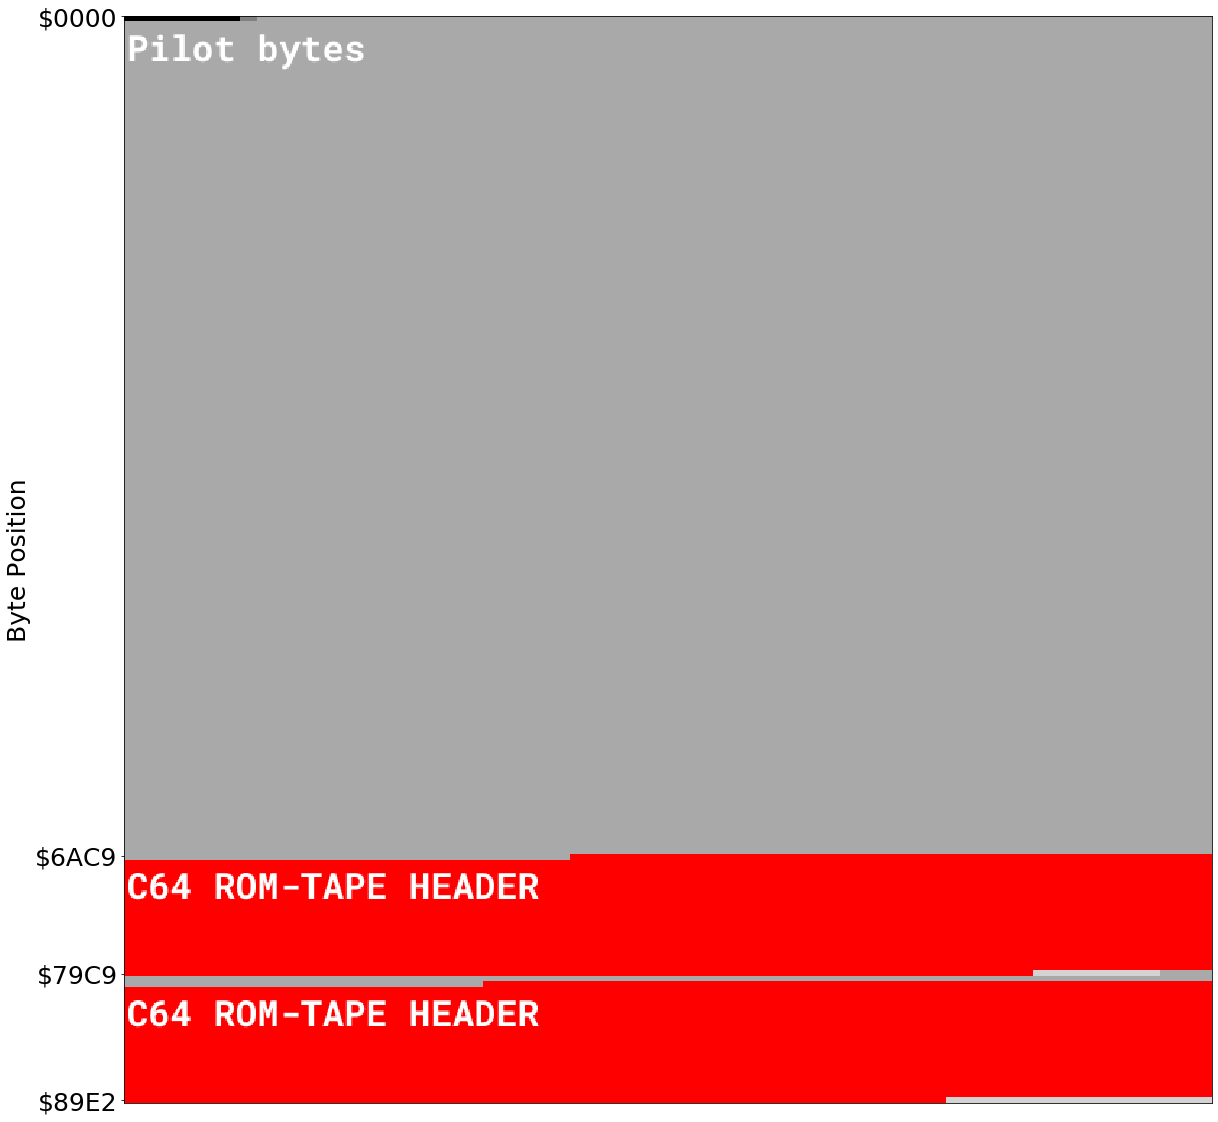

In [106]:
tmp_tap = tap_mapping[:10]
img = createImage(tmp_tap, font_size=25, min_size=30)
plt = createGraph(img, tmp_tap, min_gap=2000, label_size=25)
plt.savefig("../src/archaeo/tap-header.png", bbox_inches="tight")


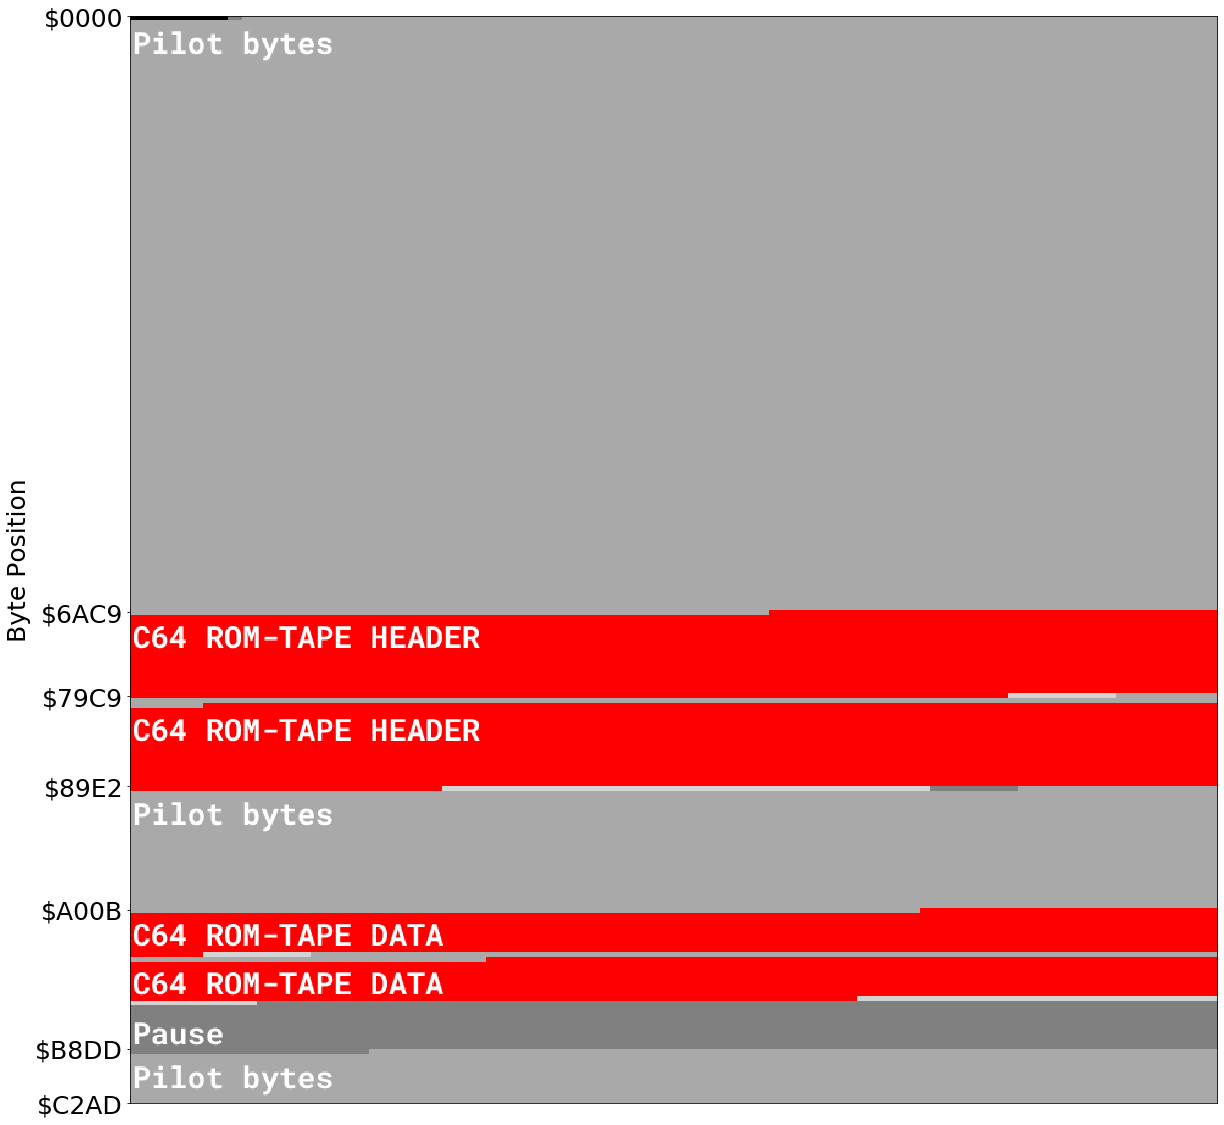

In [107]:
tmp_tap = tap_mapping[:20]
img = createImage(tmp_tap, font_size=25, min_size=30)
plt = createGraph(img, tmp_tap, min_gap=2000, label_size=25)
plt.savefig("../src/archaeo/tap-loader.png", bbox_inches="tight")


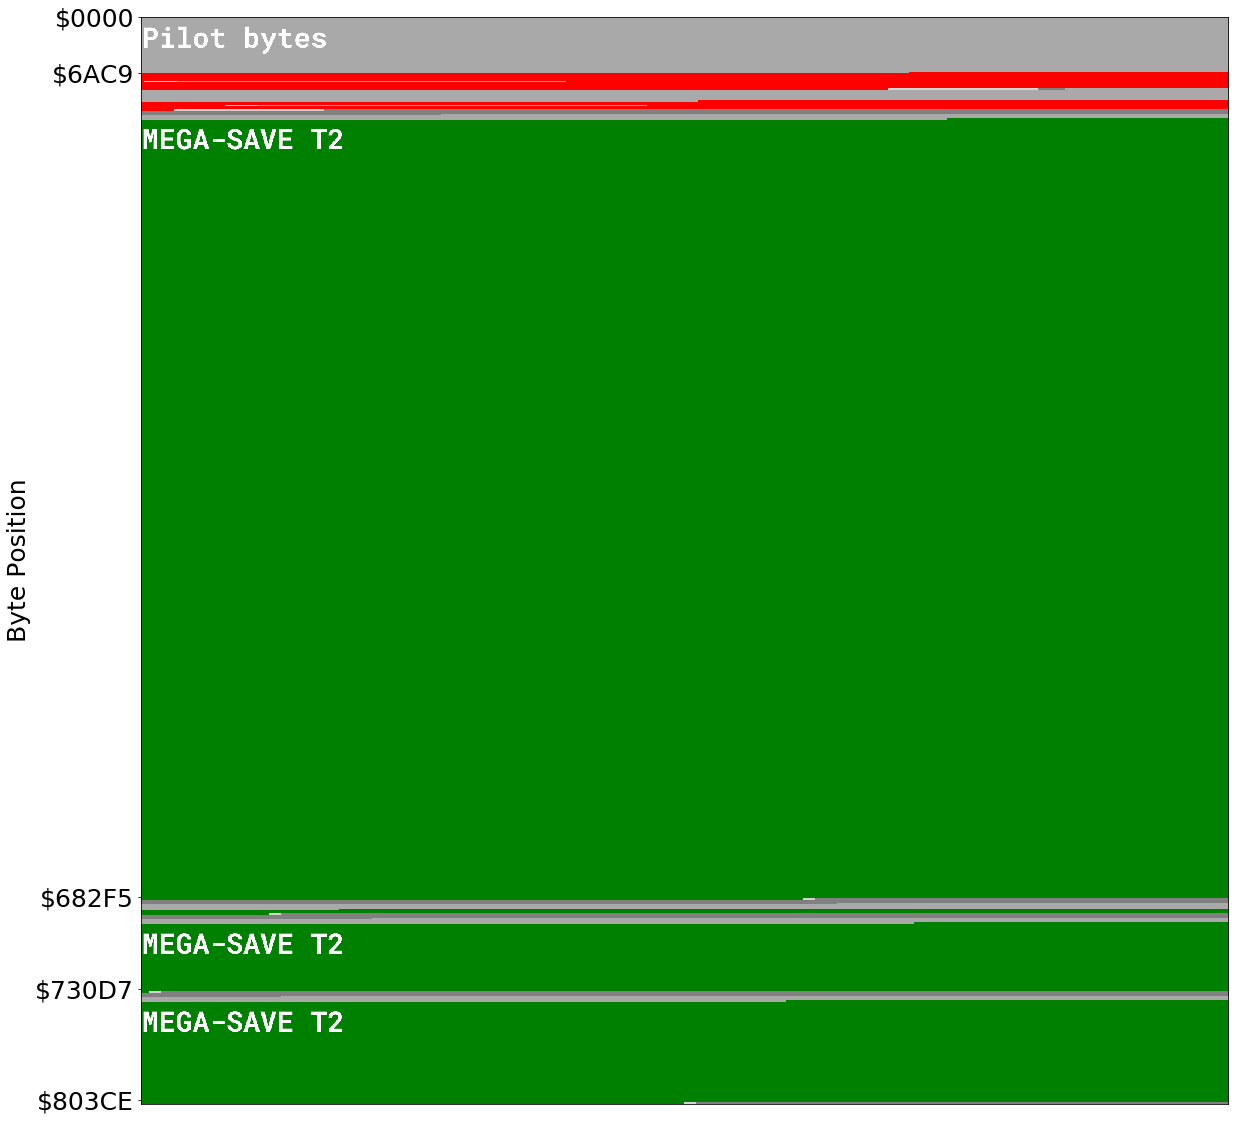

In [109]:
tmp_tap = tap_mapping
img = createImage(tmp_tap, font_size=75, min_size=30)
plt = createGraph(img, tmp_tap, min_gap=20000, label_size=25)
plt.savefig("../src/archaeo/tap-full.png", bbox_inches="tight")
